In [125]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on", device)

Training on cpu


# Data

In [127]:
df = pd.read_csv("customer_offer_dataset.csv", index_col=0).drop(columns=["cluster"])
df.head()

,gender,age,income,transaction_frequency,average_transaction_amount,click_rate,completion_rate,offer_received_A,offer_received_B,offer_received_C,...,offer_completed_A,offer_completed_B,offer_completed_C,offer_completed_D,offer_completed_E,offer_completed_F,offer_completed_G,offer_completed_H,offer_completed_I,offer_completed_J
0,1.0,55,112000.0,3.0,25.670000,0.000000,0.500000,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,1.0,75,100000.0,7.0,22.752857,1.000000,0.750000,1,0,0,...,1,0,0,1,0,0,0,0,1,0
2,0.0,68,70000.0,3.0,19.243333,0.750000,0.500000,0,0,1,...,0,0,0,1,0,0,1,0,0,0
3,0.0,65,53000.0,3.0,12.143333,1.000000,0.833333,0,0,0,...,0,0,0,1,0,0,1,0,2,1
4,0.0,58,51000.0,4.0,3.905000,0.666667,0.333333,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [128]:
offer_cols = [col for col in df.columns if "offer" in col]
offer_viewed_cols = [col for col in offer_cols if "viewed" in col]
offer_recived_cols = [col for col in offer_cols if "received" in col]
offer_completed_cols = [col for col in offer_cols if "completed" in col]

# Scaling

In [129]:
# Use min max scaling for columns [0:8]
scaler = MinMaxScaler()
df.iloc[:, 0:7] = scaler.fit_transform(df.iloc[:, 0:7])

C:\Users\asus\AppData\Local\Temp\ipykernel_22260\3062372952.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.44578313 0.68674699 0.60240964 ... 0.37349398 0.78313253 0.53012048]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [130]:
df.head()

,gender,age,income,transaction_frequency,average_transaction_amount,click_rate,completion_rate,offer_received_A,offer_received_B,offer_received_C,...,offer_completed_A,offer_completed_B,offer_completed_C,offer_completed_D,offer_completed_E,offer_completed_F,offer_completed_G,offer_completed_H,offer_completed_I,offer_completed_J
0,1.0,0.445783,0.911111,0.083333,0.056859,0.000000,0.500000,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,1.0,0.686747,0.777778,0.194444,0.050397,1.000000,0.750000,1,0,0,...,1,0,0,1,0,0,0,0,1,0
2,0.0,0.602410,0.444444,0.083333,0.042624,0.750000,0.500000,0,0,1,...,0,0,0,1,0,0,1,0,0,0
3,0.0,0.566265,0.255556,0.083333,0.026897,1.000000,0.833333,0,0,0,...,0,0,0,1,0,0,1,0,2,1
4,0.0,0.481928,0.233333,0.111111,0.008650,0.666667,0.333333,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [131]:
df.describe()

,gender,age,income,transaction_frequency,average_transaction_amount,click_rate,completion_rate,offer_received_A,offer_received_B,offer_received_C,...,offer_completed_A,offer_completed_B,offer_completed_C,offer_completed_D,offer_completed_E,offer_completed_F,offer_completed_G,offer_completed_H,offer_completed_I,offer_completed_J
count,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,...,14613.000000,14613.000000,14613.0,14613.000000,14613.000000,14613.000000,14613.000000,14613.0,14613.000000,14613.000000
mean,0.419421,0.438475,0.393730,0.232244,0.033036,0.751934,0.486482,0.450968,0.446246,0.448984,...,0.246219,0.223431,0.0,0.281530,0.227400,0.329775,0.337850,0.0,0.276192,0.263532
std,0.493481,0.209641,0.240372,0.143937,0.036686,0.236805,0.330970,0.644743,0.639463,0.644802,...,0.511710,0.488542,0.0,0.532787,0.488111,0.573016,0.577846,0.0,0.527721,0.521515
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.289157,0.211111,0.138889,0.008166,0.600000,0.200000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.445783,0.377778,0.194444,0.030937,0.800000,0.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,1.000000,0.578313,0.555556,0.305556,0.047268,1.000000,0.750000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,0.0,4.000000,3.000000,4.000000,4.000000,0.0,3.000000,4.000000


## Dataloaders

# INPUT OUT COLS

In [132]:
input_cols = list(set(df.columns) - set(offer_completed_cols) - set(offer_recived_cols) -set(offer_viewed_cols)) #-set(offer_viewed_cols) - set(offer_recived_cols))
output_cols = offer_completed_cols

input_size = len(input_cols)
out_size = len(output_cols)

print(input_cols)
print(output_cols)

['gender', 'completion_rate', 'average_transaction_amount', 'transaction_frequency', 'age', 'click_rate', 'income']
['offer_completed_A', 'offer_completed_B', 'offer_completed_C', 'offer_completed_D', 'offer_completed_E', 'offer_completed_F', 'offer_completed_G', 'offer_completed_H', 'offer_completed_I', 'offer_completed_J']


In [133]:
X_tensor = torch.tensor(df[input_cols].values, dtype=torch.float32)
Y_tensor = torch.tensor(df[output_cols].values, dtype=torch.float32)
# if any element of Y is greater than 1, then make it 1
Y_tensor[Y_tensor > 1] = 1

print(X_tensor)
print(Y_tensor)

tensor([[1.0000, 0.5000, 0.0569,  ..., 0.4458, 0.0000, 0.9111],
        [1.0000, 0.7500, 0.0504,  ..., 0.6867, 1.0000, 0.7778],
        [0.0000, 0.5000, 0.0426,  ..., 0.6024, 0.7500, 0.4444],
        ...,
        [0.0000, 0.0000, 0.0110,  ..., 0.3735, 0.3333, 0.4778],
        [1.0000, 1.0000, 0.0300,  ..., 0.7831, 1.0000, 0.2222],
        [1.0000, 0.5000, 0.0528,  ..., 0.5301, 0.5000, 0.5778]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])


In [134]:
# 20% of the data will be used for testing
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42)

# Create a dataset and a data loader
train_data = TensorDataset(X_train, Y_train)
test_data = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
test_loader = DataLoader(test_data, batch_size=512, shuffle=True)

X_train.shape, Y_train.shape, Y_train.max(), Y_train.min()

(torch.Size([11690, 7]), torch.Size([11690, 10]), tensor(1.), tensor(0.))

# Model

In [135]:
class OfferAutoEncoder(nn.Module):
    def __init__(self, input_size, out_size, num_latent_features):
        super(OfferAutoEncoder, self).__init__()

        self.num_latent_features = num_latent_features

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, num_latent_features), # Encoder output
        )

        self.decoder = nn.Sequential(
            nn.Linear(num_latent_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, out_size),
            nn.Sigmoid() # Multi label classification
        )

    def forward(self, x):
        # Encoder
        enc = self.encoder(x)

        # Decoder
        out = self.decoder(enc)

        return out, enc

# Training

In [136]:
num_latent_features = 3

model = OfferAutoEncoder(input_size, out_size, num_latent_features).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

epochs = 1000

In [137]:
train_losses = []
test_losses = []

In [138]:
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()

        output, enc = model(X)

        # Add loss to make sure enc in one hot encoding
        reconstrction_loss = criterion(output, Y)
        
        total_loss = reconstrction_loss
        total_loss.backward()

        optimizer.step()
        train_loss += total_loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, Y in test_loader:
            X, Y = X.to(device), Y.to(device)
            output, enc = model(X)
            reconstrction_loss = criterion(output, Y)
            total_loss = reconstrction_loss
            test_loss += total_loss.item()
        test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs}.. Train loss: {train_loss/len(train_loader):.6f}.. Test loss: {test_loss/len(test_loader):.6f}")

Epoch 1/1000.. Train loss: 0.679926.. Test loss: 0.664205
Epoch 2/1000.. Train loss: 0.635795.. Test loss: 0.589259
Epoch 3/1000.. Train loss: 0.529923.. Test loss: 0.478681
Epoch 4/1000.. Train loss: 0.457235.. Test loss: 0.443338
Epoch 5/1000.. Train loss: 0.437479.. Test loss: 0.431997
Epoch 6/1000.. Train loss: 0.426203.. Test loss: 0.419671
Epoch 7/1000.. Train loss: 0.412008.. Test loss: 0.403143
Epoch 8/1000.. Train loss: 0.396238.. Test loss: 0.391017
Epoch 9/1000.. Train loss: 0.387595.. Test loss: 0.384355
Epoch 10/1000.. Train loss: 0.382615.. Test loss: 0.379725
Epoch 11/1000.. Train loss: 0.379295.. Test loss: 0.378669
Epoch 12/1000.. Train loss: 0.377178.. Test loss: 0.376403
Epoch 13/1000.. Train loss: 0.375606.. Test loss: 0.375569
Epoch 14/1000.. Train loss: 0.374601.. Test loss: 0.373591
Epoch 15/1000.. Train loss: 0.373517.. Test loss: 0.373147
Epoch 16/1000.. Train loss: 0.372905.. Test loss: 0.372370
Epoch 17/1000.. Train loss: 0.372236.. Test loss: 0.371746
Epoch 

# Evaluation

In [139]:
# Evaluate model on test dataset
model.eval()
test_loss = 0
with torch.no_grad():
    for X, Y in test_data:
        X, Y = X.to(device), Y.to(device)
        X = X.unsqueeze(0)
        Y = Y.unsqueeze(0)
        output, enc = model(X)
        reconstrction_loss = criterion(output, Y)
        total_loss = reconstrction_loss
        test_loss += total_loss.item()

print(f"Test loss: {test_loss/len(test_data)}")

Test loss: 0.3581836068168773


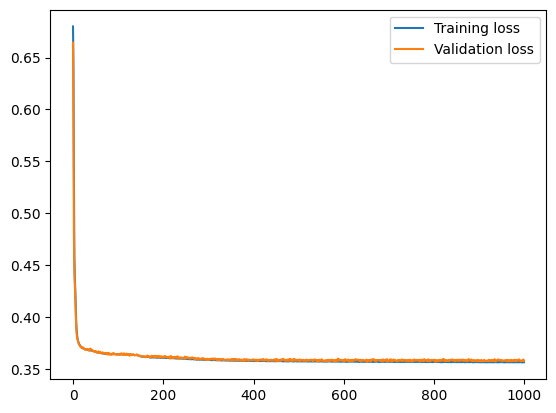

In [140]:
# Plot the loss
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.legend()
plt.show()

In [141]:
# Combine labels
out, enc = model(X_tensor.to(device))
enc

tensor([[-0.6439,  0.4809, -0.2920],
        [-0.1595, -0.4728, -1.0412],
        [-0.4893, -0.3335, -0.8989],
        ...,
        [-3.8079,  1.8300, -2.0407],
        [-0.1168, -0.3635, -0.9208],
        [-0.5971, -0.2931, -0.7108]], grad_fn=<AddmmBackward0>)

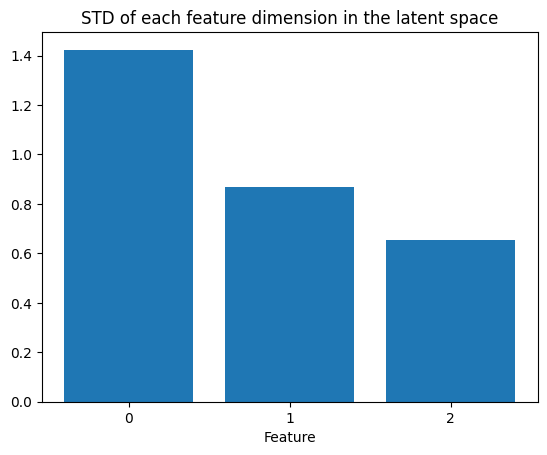

In [142]:
# Plot the distribution of the clusters
plt.bar(range(num_latent_features), enc.std(dim=0).detach().cpu().numpy())
plt.xlabel("Feature")
plt.title("STD of each feature dimension in the latent space")
plt.xticks(range(num_latent_features))
plt.show()

In [143]:
cluster_df = df.copy()
feature_cols = [f"feature_{i}" for i in range(num_latent_features)]
feature_cols

['feature_0', 'feature_1', 'feature_2']

In [144]:
cluster_df = pd.DataFrame(enc.detach().cpu().numpy(), columns=feature_cols)
cluster_df.head()

,feature_0,feature_1,feature_2
0,-0.643923,0.480916,-0.292013
1,-0.159534,-0.472814,-1.041213
2,-0.489255,-0.333534,-0.898909
3,-0.121857,-0.255483,-0.895599
4,-0.618051,0.316450,-1.319390


# Clustering

In [145]:
from sklearn.cluster import KMeans

losses = []

for i in tqdm(range(2, 20)):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(cluster_df)
    losses.append(kmeans.inertia_)

  0%|          | 0/18 [00:00<?, ?it/s]

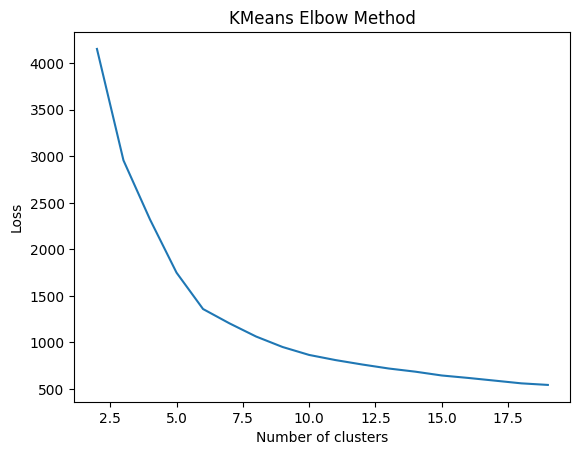

In [146]:
plt.plot(range(2, 20), losses)
plt.xlabel("Number of clusters")
plt.ylabel("Loss")
plt.title("KMeans Elbow Method")
plt.show()

In [147]:
# Add cluster id to the dataframe
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_df["cluster"] = kmeans.fit_predict(cluster_df)
cluster_df.head()

,feature_0,feature_1,feature_2,cluster
0,-0.643923,0.480916,-0.292013,2
1,-0.159534,-0.472814,-1.041213,1
2,-0.489255,-0.333534,-0.898909,1
3,-0.121857,-0.255483,-0.895599,1
4,-0.618051,0.316450,-1.319390,2


# TSNE

In [148]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(cluster_df)

tsne_df = pd.DataFrame(tsne_transformed, columns=["x", "y"])
tsne_df.head()

,x,y
0,-11.294034,39.967903
1,-55.734428,-33.047676
2,20.444942,-15.439536
3,-25.684795,-39.464935
4,26.887024,51.411034


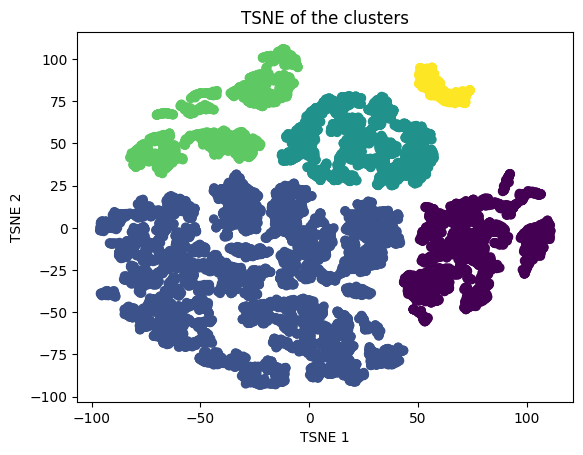

In [149]:
plt.scatter(tsne_df["x"], tsne_df["y"], cmap="viridis", c=cluster_df["cluster"])
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the clusters")
plt.show()

In [150]:
merged_df = pd.concat([df, tsne_df, cluster_df], axis=1)
merged_df.head()

,gender,age,income,transaction_frequency,average_transaction_amount,click_rate,completion_rate,offer_received_A,offer_received_B,offer_received_C,...,offer_completed_G,offer_completed_H,offer_completed_I,offer_completed_J,x,y,feature_0,feature_1,feature_2,cluster
0,1.0,0.445783,0.911111,0.083333,0.056859,0.000000,0.500000,0,0,1,...,0,0,0,0,-11.294034,39.967903,-0.643923,0.480916,-0.292013,2
1,1.0,0.686747,0.777778,0.194444,0.050397,1.000000,0.750000,1,0,0,...,0,0,1,0,-55.734428,-33.047676,-0.159534,-0.472814,-1.041213,1
2,0.0,0.602410,0.444444,0.083333,0.042624,0.750000,0.500000,0,0,1,...,1,0,0,0,20.444942,-15.439536,-0.489255,-0.333534,-0.898909,1
3,0.0,0.566265,0.255556,0.083333,0.026897,1.000000,0.833333,0,0,0,...,1,0,2,1,-25.684795,-39.464935,-0.121857,-0.255483,-0.895599,1
4,0.0,0.481928,0.233333,0.111111,0.008650,0.666667,0.333333,0,0,1,...,1,0,0,0,26.887024,51.411034,-0.618051,0.316450,-1.319390,2


In [151]:
import plotly.express as px

fig = px.scatter(merged_df, x="x", y="y", hover_data=output_cols,
                 color="cluster", title="Clusters", width=800, height=800, 
                 color_continuous_scale="viridis")
fig.show()

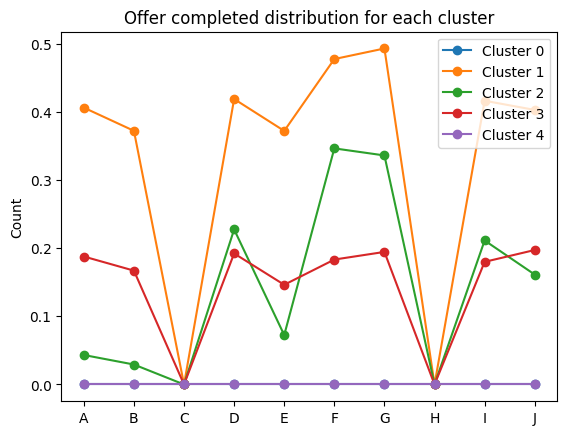

In [152]:
# Plot distribution of offer completed for each cluster
for i in range(num_clusters):
    plt.plot([i[16:] for i in output_cols],
             merged_df[merged_df["cluster"] == i][offer_completed_cols].mean().values, 
             label=f"Cluster {i}", marker="o")
plt.ylabel("Count")
plt.title("Offer completed distribution for each cluster")
plt.legend()
plt.show()